In [4]:
!pip install tensorflow_hub
!pip install tensorflow_datasets

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 3.4 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 177 kB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 44 kB 3.4 MB/s  eta 0:00:01
     |████████████████████████████████| 100 kB 4.9 MB/s ta 0:00:01
  Created wheel for dill: filename=dill-0.3.2-py3-none-any.whl size=81196 sha256=2a6575389393e714990e7e5f848c60a9e1eff65569351f948d31366688204324
  Stored in directory: /root/.cache/pip/wheels/02/49/cf/660924cd9bc5fcddc3a0246fe39800c83028d3ccea244de352
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=23950 sha256=7966cc2ea9c1194516afde96170fe18e446ff91839385740766b05b3cc477f4c
  Stored in directory: /root/.cache/pip/wheels/59/9a/1d/3f1afbbb5122d0410547bf9eb50955f4a7a98e53a6d8b99bd1
Successfully built dill promise
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' comman

In [1]:
import re
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt

In [2]:
from data_util import *
from lars_optimizer import LARSOptimizer

In [3]:
tf_flowers_labels = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

## Load tensorflow datasets -- use flower for now

In [4]:
batch_size = 64
dataset_name = 'tf_flowers'

tfds_dataset, tfds_info = tfds.load(
    dataset_name, split='train', with_info=True)
num_images = tfds_info.splits['train'].num_examples
num_classes = tfds_info.features['label'].num_classes

def _preprocess(x):
  x['image'] = preprocess_image(
      x['image'], 224, 224, is_training=False, color_distort=False)
  return x
x = tfds_dataset.map(_preprocess).batch(batch_size)
x = tf.data.make_one_shot_iterator(x).get_next()

In [5]:
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.

# Load the base network and set it to non-trainable (for speedup fine-tuning)
hub_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/hub/'
module = hub.Module(hub_path, trainable=False)
key = module(inputs=x['image'], signature="default", as_dict=True)

# Attach a trainable linear layer to adapt for the new task.
with tf.variable_scope('head_supervised_new', reuse=tf.AUTO_REUSE):
  logits_t = tf.layers.dense(inputs=key['final_avg_pool'], units=num_classes)
loss_t = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=tf.one_hot(x['label'], num_classes), logits=logits_t))

# Setup optimizer and training op.
optimizer = LARSOptimizer(
    learning_rate,
    momentum=momentum,
    weight_decay=weight_decay,
    exclude_from_weight_decay=['batch_normalization', 'bias', 'head_supervised'])
variables_to_train = tf.trainable_variables() 
train_op = optimizer.minimize(
    loss_t, global_step=tf.train.get_or_create_global_step(),
    var_list=variables_to_train)

print('Variables to train:', variables_to_train)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Variables to train: [<tf.Variable 'head_supervised_new/dense/kernel:0' shape=(2048, 5) dtype=float32>, <tf.Variable 'head_supervised_new/dense/bias:0' shape=(5,) dtype=float32>]


In [6]:
key

{'block_group1': <tf.Tensor 'module_apply_default/base_model/block_group1:0' shape=(None, 56, 56, 256) dtype=float32>,
 'block_group2': <tf.Tensor 'module_apply_default/base_model/block_group2:0' shape=(None, 28, 28, 512) dtype=float32>,
 'block_group3': <tf.Tensor 'module_apply_default/base_model/block_group3:0' shape=(None, 14, 14, 1024) dtype=float32>,
 'block_group4': <tf.Tensor 'module_apply_default/base_model/block_group4:0' shape=(None, 7, 7, 2048) dtype=float32>,
 'final_avg_pool': <tf.Tensor 'module_apply_default/base_model/final_avg_pool:0' shape=(None, 2048) dtype=float32>,
 'initial_max_pool': <tf.Tensor 'module_apply_default/base_model/initial_max_pool:0' shape=(None, 56, 56, 64) dtype=float32>,
 'logits_sup': <tf.Tensor 'module_apply_default/head_supervised/linear_layer/linear_layer_out:0' shape=(None, 1000) dtype=float32>,
 'initial_conv': <tf.Tensor 'module_apply_default/base_model/initial_conv:0' shape=(None, 112, 112, 64) dtype=float32>,
 'default': <tf.Tensor 'module

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
#@title We fine-tune the new *linear layer* for just a few iterations.

total_iterations =10

for it in range(total_iterations):
  _, loss, image, logits, labels = sess.run((train_op, loss_t, x['image'], logits_t, x['label']))
  pred = logits.argmax(-1)
  correct = np.sum(pred == labels)
  total = labels.size
  print("[Iter {}] Loss: {} Top 1: {}".format(it+1, loss, correct/float(total)))

[Iter 1] Loss: 1.6027135848999023 Top 1: 0.359375
[Iter 2] Loss: 1.1781554222106934 Top 1: 0.484375
[Iter 3] Loss: 0.7387629747390747 Top 1: 0.734375
[Iter 4] Loss: 0.9474406242370605 Top 1: 0.765625
[Iter 5] Loss: 0.698793351650238 Top 1: 0.734375
[Iter 6] Loss: 0.47370320558547974 Top 1: 0.84375
[Iter 7] Loss: 0.7436432838439941 Top 1: 0.8125
[Iter 8] Loss: 0.49842989444732666 Top 1: 0.859375
[Iter 9] Loss: 0.3133441209793091 Top 1: 0.90625
[Iter 10] Loss: 0.34276533126831055 Top 1: 0.875


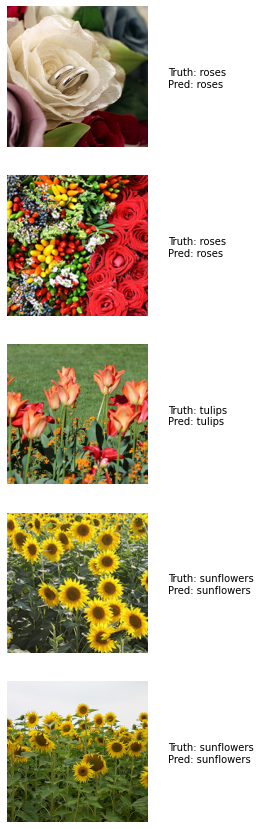

In [9]:
#@title Plot the images and predictions
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
for i in range(5):
  axes[i].imshow(image[i])
  true_text = tf_flowers_labels[labels[i]]
  pred_text = tf_flowers_labels[pred[i]]
  axes[i].axis('off')
  axes[i].text(256, 128, 'Truth: ' + true_text + '\n' + 'Pred: ' + pred_text)